# Avaliação de ISGD contínuo em holdouts - Movielens

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
import pandas as pd 
import numpy as np 
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [3]:
# importa dataset 'movielensm1'
data = pd.read_csv("../../datasets/ml1m_gte5.csv","\t")

# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
# stream = ImplicitData(data['UserID'].to_list(), data['ItemID'].to_list())
stream = ImplicitData(data['UserID'], data['ItemID'])

empty_stream = ImplicitData([], [])

In [4]:
num_factors = 160
num_iter = 8
learn_rate = 0.1
regularization = 0.4
num_nodes = 8

___
TREINO COM MOVIELENS

In [5]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [6]:
eval = EvaluateAndStore(model=model,data=stream,n_holdouts=20,metrics = ["Recall@20"])

In [7]:
results=eval.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True)

A seguir calculamos uma matrix de resultados - todos os checkpoints de modelo avaliados em todos os holdouts.
Exclude known items está LIGADO.

In [8]:
eval.EvaluateHoldouts(exclude_known_items=True)

In [9]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1)
df.to_csv('output/movielens1m results_matrix.csv', index=False)

In [8]:
# Read results:
rm1 = pd.read_csv('output/movielens1m results_matrix.csv')

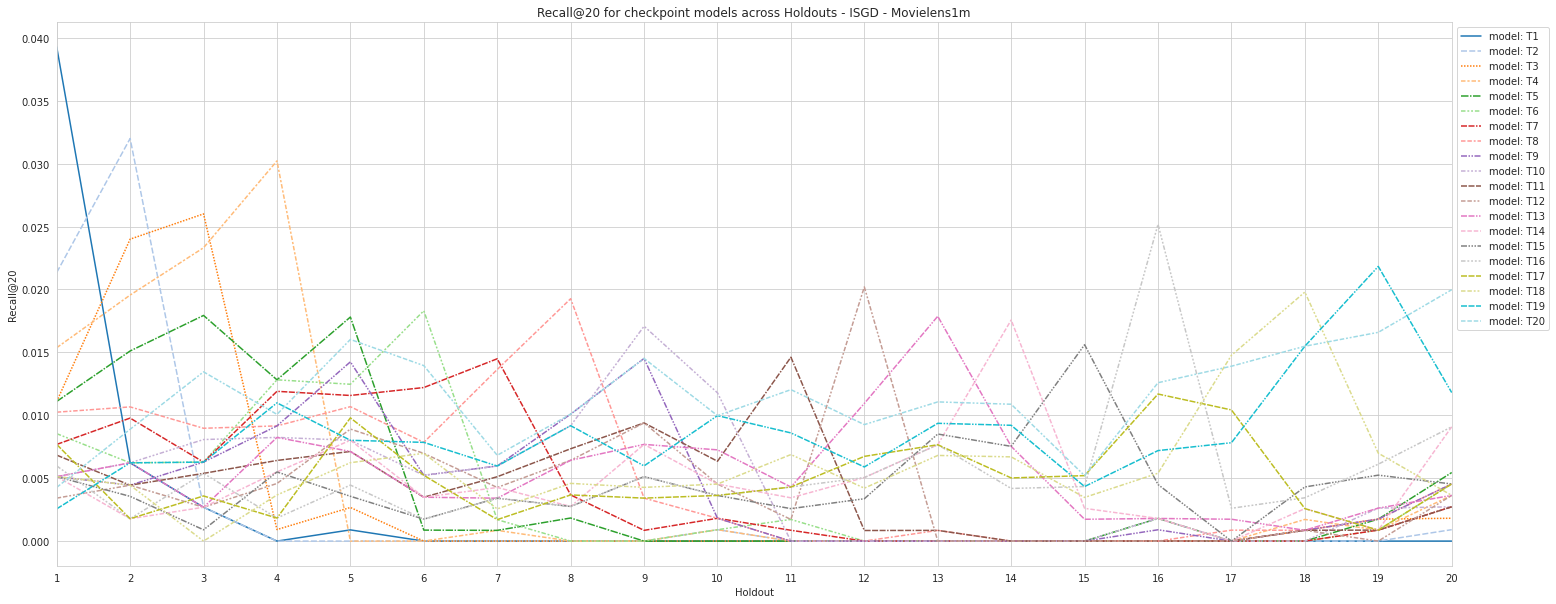

In [11]:
plt.figure(figsize=(25,10))
sns.lineplot(data=rm1, palette='tab20')
x_t = np.arange(0,20)
plt.xticks(x_t, labels=[str(i+1) for i in x_t])
plt.xlim(0, 19)
plt.xlabel('Holdout')
plt.ylabel('Recall@20')
plt.legend(bbox_to_anchor=(1.0,1), loc="upper left", labels=[f'model: T{model+1}' for model in range( rm1.shape[0] )])
plt.title('Recall@20 for checkpoint models across Holdouts - ISGD - Movielens1m')
plt.savefig('output/recall20 lineplot movielens1m');

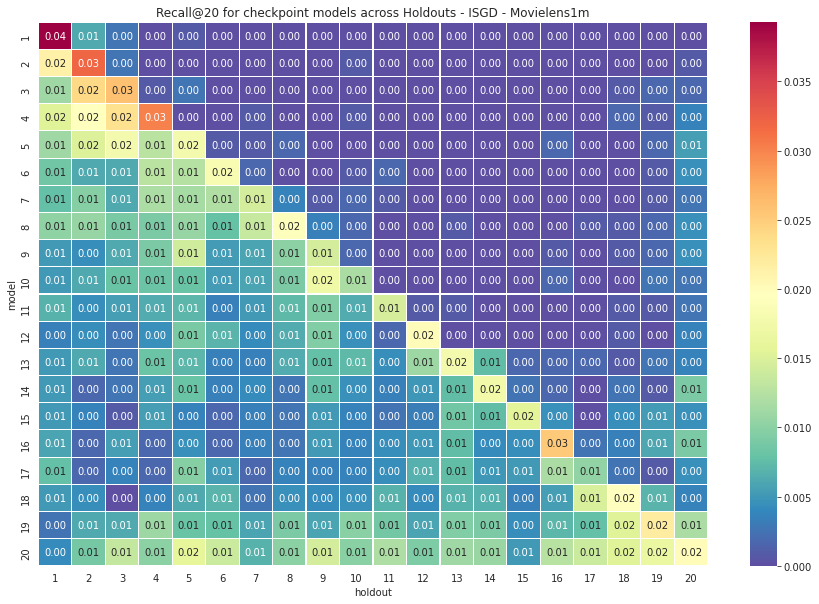

In [11]:
plt.figure(figsize=(15, 10))
x_t = np.arange(0,20)
labels=[str(i+1) for i in x_t]
sns.heatmap(rm1.T, vmin=0, vmax=rm1.max().max(), annot=True, fmt='0.2f', linewidths=.1, cmap='Spectral_r', xticklabels=labels, yticklabels=labels)
plt.ylabel('model')
plt.xlabel('holdout')
plt.title('Recall@20 for checkpoint models across Holdouts - ISGD - Movielens1m');
plt.savefig('output/recall20 heatmap movielens1m');

In [9]:
def matrix_euclidean_distance(p, q):
    return np.sqrt( np.sum( ( np.array(p) - np.array(q) )**2 ) )

user_factor_diff = np.zeros(shape=(20, 20))
item_factor_diff = np.zeros(shape=(20, 20))

for i in range( len( eval.model_checkpoints ) ):
    model_a = eval.model_checkpoints[i]
    for j in range( i, len( eval.model_checkpoints ) ):
        model_b = eval.model_checkpoints[j]

        user_factors_a = model_a.user_factors
        user_factors_b = model_b.user_factors
        item_factors_a = model_a.item_factors
        item_factors_b = model_b.item_factors

        user_len_dif = len(  user_factors_b ) - len(  user_factors_a )
        user_factors_a += [np.zeros(shape=(num_factors,)) for _ in range(user_len_dif)]
        item_len_dif = len(  item_factors_b ) - len(  item_factors_a )
        item_factors_a += [np.zeros(shape=(num_factors,)) for _ in range(item_len_dif)]

        user_factor_diff[i, j] = matrix_euclidean_distance(user_factors_a, user_factors_b)
        item_factor_diff[i, j] = matrix_euclidean_distance(item_factors_a, item_factors_b)

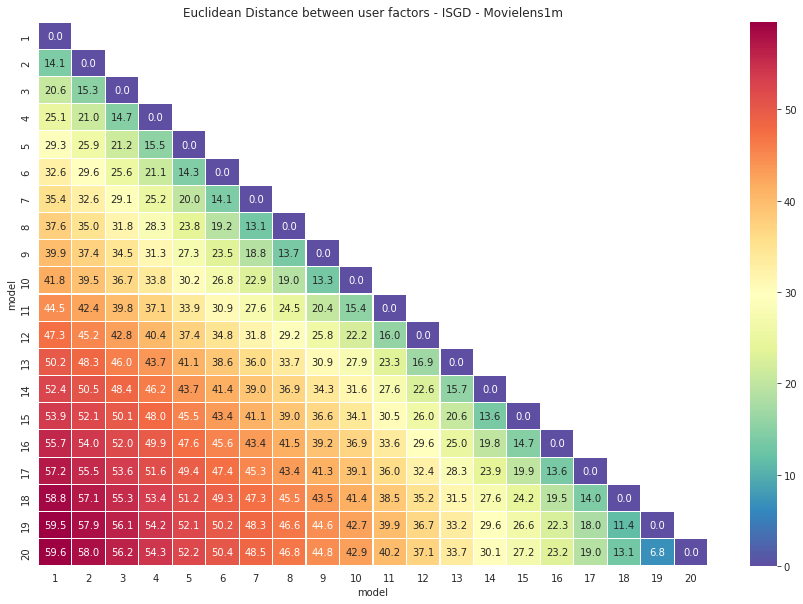

In [12]:
mask = np.zeros_like(user_factor_diff, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False
plt.figure(figsize=(15, 10))
sns.heatmap( user_factor_diff.T, mask=mask, annot=True, fmt='0.1f', linewidths=.1, cmap='Spectral_r', xticklabels=labels, yticklabels=labels) 
plt.ylabel('model')
plt.xlabel('model')
plt.title('Euclidean Distance between user factors - ISGD - Movielens1m');
plt.savefig('output/ED user_factors heatmap movielens1m');

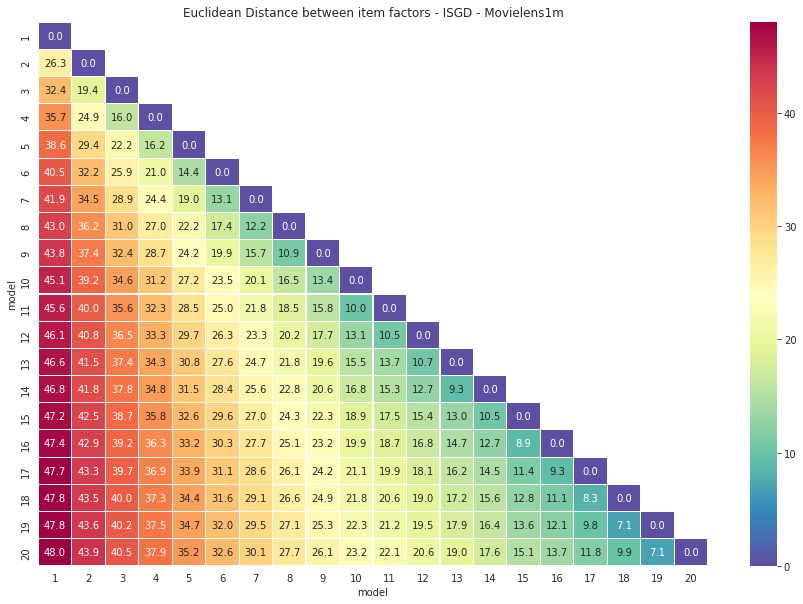

In [13]:
mask = np.zeros_like(user_factor_diff, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False
plt.figure(figsize=(15, 10))
sns.heatmap( item_factor_diff.T, mask=mask, annot=True, fmt='0.1f', linewidths=.1, cmap='Spectral_r', xticklabels=labels, yticklabels=labels) 
plt.ylabel('model')
plt.xlabel('model')
plt.title('Euclidean Distance between item factors - ISGD - Movielens1m');
plt.savefig('output/ED item_factors heatmap movielens1m');

___

# Shuffled Dataset

In [13]:
shuffled_data = data.sample(frac=1).reset_index(drop=True).copy()

In [14]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
stream = ImplicitData(shuffled_data['UserID'].to_list(), shuffled_data['ItemID'].to_list()) 

empty_stream = ImplicitData([], [])

In [15]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [16]:
eval = EvaluateAndStore(model=model,data=stream,n_holdouts=20,metrics = ["Recall@20"])

In [17]:
results=eval.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True)

A seguir calculamos uma matrix de resultados - todos os checkpoints de modelo avaliados em todos os holdouts.
Exclude known items está LIGADO.

In [18]:
eval.EvaluateHoldouts(exclude_known_items=True)

In [19]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1)
df.to_csv('output/shuffled movielens1m results_matrix.csv', index=False)

In [20]:
# # Read results:
# rm1 = pd.read_csv('output/shuffled movielens1m results_matrix.csv')

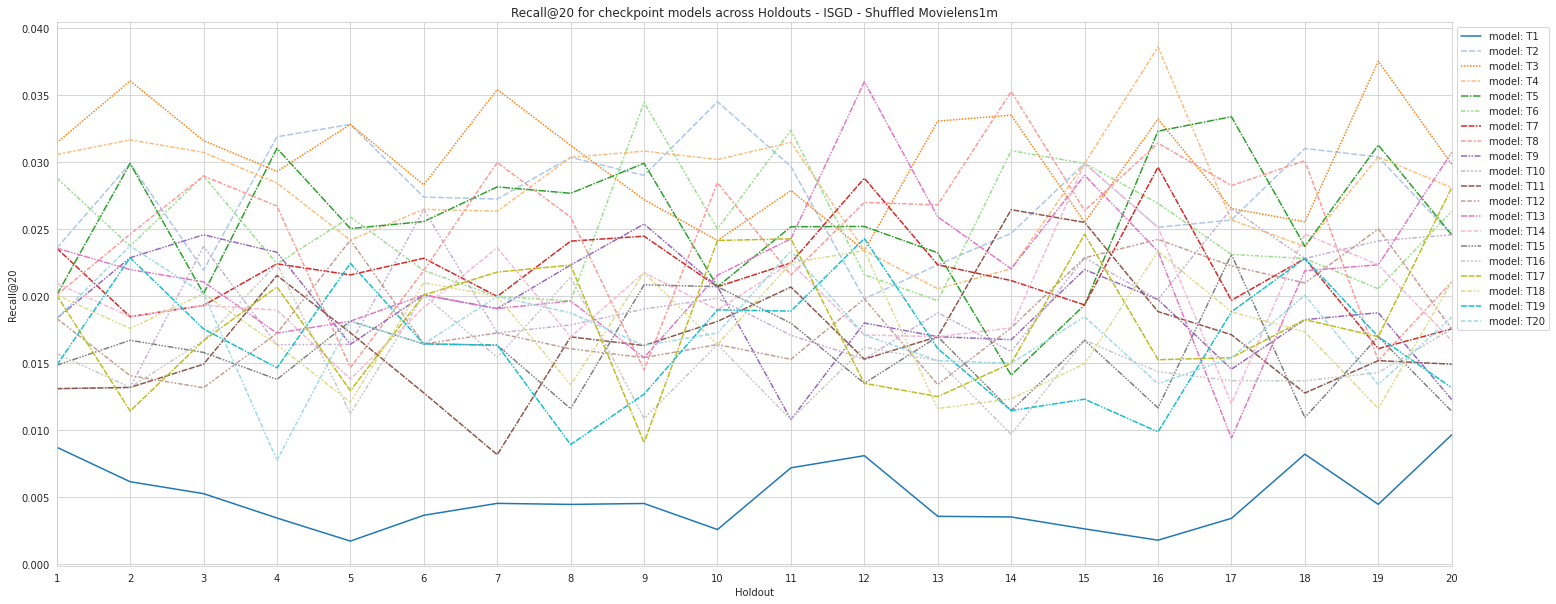

In [21]:
plt.figure(figsize=(25,10))
sns.lineplot(data=rm1, palette='tab20')
x_t = np.arange(0,20)
plt.xticks(x_t, labels=[str(i+1) for i in x_t])
plt.xlim(0, 19)
plt.xlabel('Holdout')
plt.ylabel('Recall@20')
plt.legend(bbox_to_anchor=(1.0,1), loc="upper left", labels=[f'model: T{model+1}' for model in range( rm1.shape[0] )])
plt.title('Recall@20 for checkpoint models across Holdouts - ISGD - Shuffled Movielens1m')
plt.savefig('output/recall20 lineplot shuffled movielens1m');

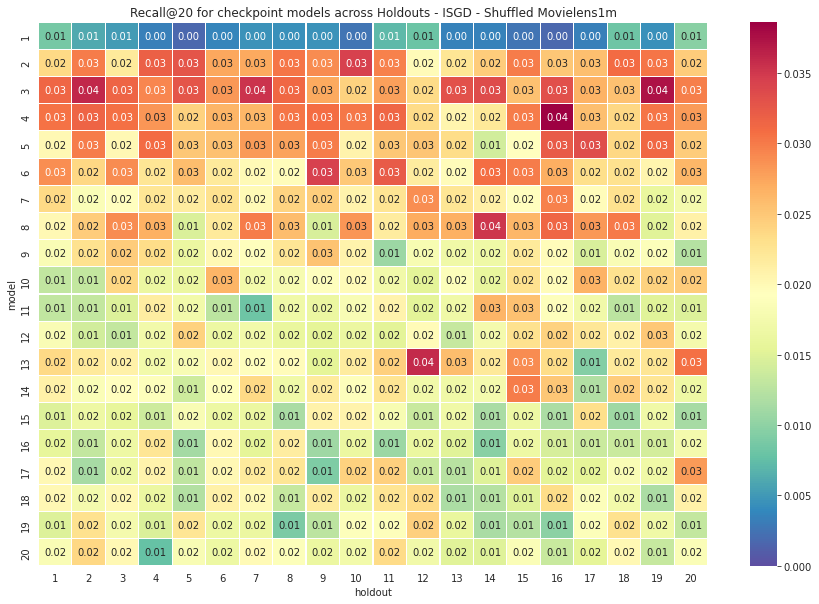

In [22]:
plt.figure(figsize=(15, 10))
x_t = np.arange(0,20)
labels=[str(i+1) for i in x_t]
sns.heatmap(rm1.T, vmin=0, vmax=rm1.max().max(), annot=True, fmt='0.2f', linewidths=.1, cmap='Spectral_r', xticklabels=labels, yticklabels=labels)
plt.ylabel('model')
plt.xlabel('holdout')
plt.title('Recall@20 for checkpoint models across Holdouts - ISGD - Shuffled Movielens1m');
plt.savefig('output/recall20 heatmap shuffled movielens1m');